In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

## Q1: Number of records

In [3]:
org_df_shape = df.shape
print(f'Number of records: {org_df_shape[0]}')

Number of records: 1154112


In [4]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [5]:
pickup_dt = pd.to_datetime(df['pickup_datetime'])
drop_dt = pd.to_datetime(df['dropOff_datetime'])

## Q2: Calculate mean duration

In [6]:
df['duration'] = (drop_dt - pickup_dt)

In [7]:
mean_duration = df['duration'].mean().total_seconds() / 60
print(f'Mean duration is {mean_duration:.3f} min')

Mean duration is 19.167 min


### Remove outlliers

In [8]:
df['duration'] = df['duration'].dt.total_seconds()
df['duration'] = df['duration'] / 60

In [9]:
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [10]:
dropped_records = org_df_shape[0] - df.shape[0]
print(f'Dropped {dropped_records} records')

Dropped 44286 records


In [11]:
df['PUlocationID'].fillna(value=-1, inplace=True)
df['DOlocationID'].fillna(value=-1, inplace=True)

## Q3: Calculate missing values percentage

In [12]:
num_fill_na = df[(df['PUlocationID'] == -1.0) | (df['DOlocationID'] == -1.0)].shape[0]

print(f'Found {num_fill_na} missing values | Percentage: {num_fill_na*100/df.shape[0]:.2f} %')

Found 938156 missing values | Percentage: 84.53 %


In [13]:
categorical = ['PUlocationID', 'DOlocationID']
numerical = ['duration']

df[categorical] = df[categorical].astype(str)

df[categorical + numerical].head()

,PUlocationID,DOlocationID,duration
0,-1.0,-1.0,17.000000
1,-1.0,-1.0,17.000000
3,-1.0,72.0,8.283333
4,-1.0,61.0,15.216667
5,-1.0,71.0,9.050000


## Q4: One-hot encoding

In [14]:
train_dicts = df[categorical].to_dict(orient='records')

In [15]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_train.shape

(1109826, 525)

In [16]:
print(f'Got {len(dv.feature_names_)} dimensions after transform')

Got 525 dimensions after transform


In [17]:
target = 'duration'
y_train = df[target].values

## Q5: Train model

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_train)

### View fit vs actual

/home/user/Documents/mlops-camp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/Documents/mlops-camp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

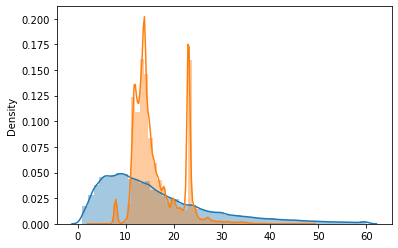

In [20]:
sns.distplot(y_train, label='actual')
sns.distplot(y_pred, label='prediction')

In [21]:
from sklearn.metrics import mean_squared_error

### Calculate RMSE

In [22]:
print(f'Achieved RMSE of {mean_squared_error(y_train, y_pred, squared=False):.3f} on training data')

Achieved RMSE of 10.529 on training data


## Q6: Get validation RMSE on February data

In [23]:
df_val = pd.read_parquet('data/fhv_tripdata_2021-02.parquet')

In [24]:
pickup_dt_val = pd.to_datetime(df_val['pickup_datetime'])
drop_dt_val = pd.to_datetime(df_val['dropOff_datetime'])

In [25]:
df_val['duration'] = (drop_dt_val - pickup_dt_val)

In [26]:
mean_duration = df_val['duration'].mean().total_seconds() / 60
print(f'Mean duration is {mean_duration:.3f} min')

Mean duration is 20.707 min


In [27]:
df_val['duration'] = df_val['duration'].dt.total_seconds()
df_val['duration'] = df_val['duration'] / 60
df_val = df_val[(df_val['duration'] >= 1) & (df_val['duration'] <= 60)]

In [28]:
df_val['PUlocationID'].fillna(value=-1, inplace=True)
df_val['DOlocationID'].fillna(value=-1, inplace=True)
df_val[categorical] = df_val[categorical].astype(str)

In [29]:
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_val = df_val[target].values
y_pred = lr.predict(X_val)

val_rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'RMSE of {val_rmse:.2f} on validation data')

RMSE of 11.01 on validation data
